# Predicting Financial Time Series Data with Machine Learning

This is a sample that predicts future prices from past price movements.
Here we implement it with EUR/USD rate as an example, but you can convert it to stock price by editing the symbol.


In [1]:
import datetime
import numpy as np
import pandas as pd
#from matplotlib.finance import quotes_historical_yahoo_ochl
import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.core.display import display
from IPython.display import display, clear_output
import yfinance as yf
%matplotlib inline


# time period
d1 = datetime.datetime(2008, 1, 1)
d2 = datetime.datetime(2016, 12, 31)

# Fetching data from yahoo finance
# List of Symbols : http://finance.yahoo.com/webservice/v1/symbols/allcurrencies/quote 
#q = quotes_historical_yahoo_ochl('EUR=X', d1, d2, asobject=True)


df = yf.download("EURUSD=X", d1, d2, interval='1d')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-01,1.460110,1.462994,1.458194,1.462010,1.462010,0
2008-01-02,1.462309,1.474296,1.460110,1.471692,1.471692,0
2008-01-03,1.471692,1.477891,1.469400,1.474491,1.474491,0
2008-01-04,1.474709,1.481811,1.469896,1.475492,1.475492,0
2008-01-07,1.475209,1.475209,1.466706,1.468299,1.468299,0
...,...,...,...,...,...,...
2016-12-26,1.045588,1.047011,1.044600,1.045478,1.045478,0
2016-12-27,1.045577,1.046134,1.043536,1.045697,1.045697,0
2016-12-28,1.046244,1.048218,1.038745,1.046233,1.046233,0


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-01,0.68488,0.68353,0.68578,0.68399,0.68399,0
2008-01-02,0.68385,0.67829,0.68488,0.67949,0.67949,0
2008-01-03,0.67949,0.67664,0.68055,0.67820,0.67820,0
2008-01-04,0.67810,0.67485,0.68032,0.67774,0.67774,0
2008-01-07,0.67787,0.67787,0.68180,0.68106,0.68106,0


<Axes: xlabel='Date'>

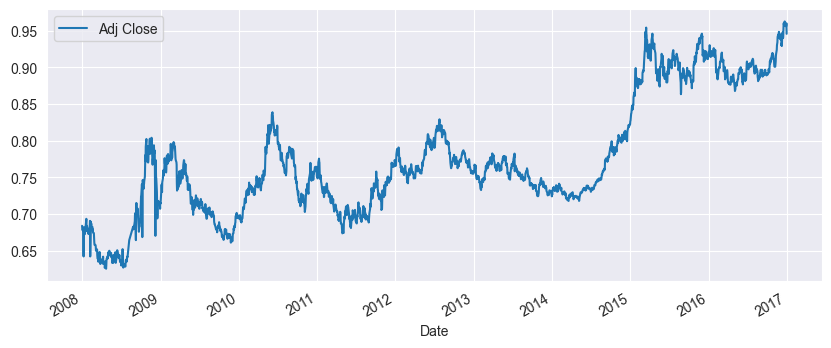

In [2]:
# Put data into Pandas Dataframe
df = pd.DataFrame(df)
#df.drop(['year','month','day','d'], inplace=True, axis=1)
cols = ['Open','High','Low','Close','Adj Close']
df[cols] = df[cols].map(lambda x: 1.0/x)
display(df.head())
df.plot( y='Adj Close', figsize=(10,4))

<Axes: xlabel='Date'>

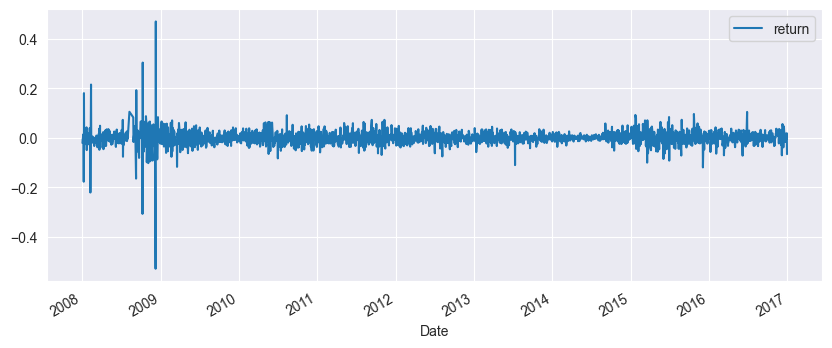

In [3]:
# Normalize aclose value
# We use this value to train model

df['return'] = df['Adj Close'] - df['Adj Close'].shift(1)
return_range = df['return'].max() - df['return'].min()
df['return'] = df['return'] / return_range

df.plot( y='return', figsize=(10,4))

In [4]:
# Make label, 1 as rising price, 0 as falling price

df['label'] = df['return'].shift(-1)
df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
# df.dropna(inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,return,label
Date,,,,,,,,
2016-12-26,0.95640,0.9551,0.957304,0.95650,0.95650,0,-0.007159,0
2016-12-27,0.95641,0.9559,0.958280,0.95630,0.95630,0,-0.000912,0
2016-12-28,0.95580,0.9540,0.962700,0.95581,0.95581,0,-0.002234,1
2016-12-29,0.95990,0.9532,0.959900,0.95997,0.95997,0,0.018968,0
2016-12-30,0.94616,0.9442,0.951475,0.94560,0.94560,0,-0.065521,0


In [5]:
# Make training dataset

n_features = 60 # number of features

train_x = np.array([]).reshape([-1,n_features])
train_y = np.array([]).reshape([-1,1])
for index, row in df.iterrows():
    i = df.index.get_loc(index)
    if i<n_features:
        continue
    
    _x = np.array(df[i-n_features+1:i+1]['return']).T.reshape([1, -1])
    _y = df.iloc[i]['label']
    train_x = np.vstack((train_x, _x))
    train_y = np.vstack((train_y, _y))
train_y = train_y.reshape([-1])
print(train_x.shape)
print(train_y.shape)
print('%% of Class0 : %f' % (np.count_nonzero(train_y == 0)/float(len(train_y))))
print('%% of Class1 : %f' % (np.count_nonzero(train_y == 1)/float(len(train_y))))

(2268, 60)
(2268,)
% of Class0 : 0.500000
% of Class1 : 0.500000


In [6]:
# Define Model and fit
# Here we use 95% of data for training, and last 5% for testing

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=10000)

train_len = int(len(train_x)*0.95)
clf.fit(train_x[:train_len], train_y[:train_len])

accuracy = clf.score(train_x[train_len:], train_y[train_len:])
print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.438596


,return,label,pred,won,pnl,equity
108,-0.00157,0.0,1.0,False,-15.700356,-377.597108
109,-0.00020,0.0,1.0,False,-1.999809,-379.596917
110,-0.00049,0.0,1.0,False,-4.900030,-384.496947
111,0.00416,1.0,1.0,True,41.600632,-342.896315
112,-0.01437,0.0,0.0,True,143.701138,-199.195177


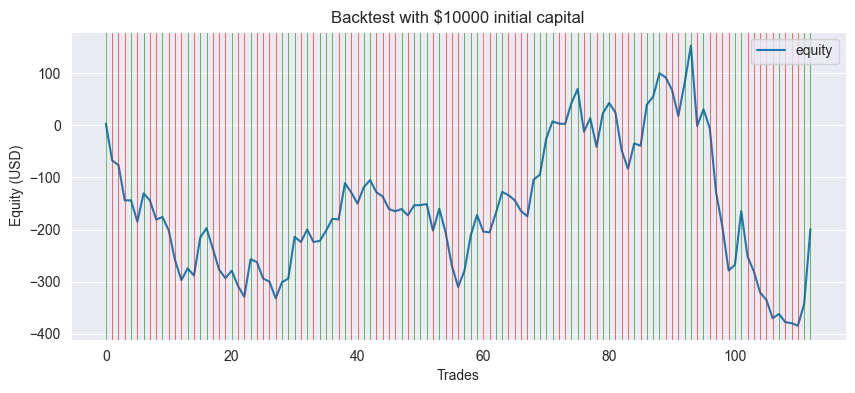

In [7]:
# Predict test data

pred = clf.predict(train_x[train_len:])


# Calculate equity..

contracts  = 10000.0
commission = 0.0


df_trade = pd.DataFrame(train_x[train_len:,-1], columns=['return'])
df_trade['label']  = train_y[train_len:]
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']
df_trade['return'] = df_trade['return'].shift(-1) * return_range
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts - commission
    else:
        return -abs(row['return'])*contracts - commission

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()

display(df_trade.tail())
df_trade.plot(y='equity', figsize=(10,4), title='Backtest with $10000 initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for r in df_trade.iterrows():
    if r[1]['won']:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='r')

Net Profit            : $-199.20
Number Winning Trades : 49
Number Losing Trades  : 63
Percent Profitable    : 43.75%
Avg Win Trade         : $38.098
Avg Los Trade         : $-32.794
Largest Win Trade     : $143.701
Largest Los Trade     : $-154.000
Profit Factor         : 0.90


C:\Users\grigo\AppData\Local\Temp\ipykernel_12644\997115733.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Net Profit            : $%.2f" % df_trade.tail(1)['equity'])


<Axes: >

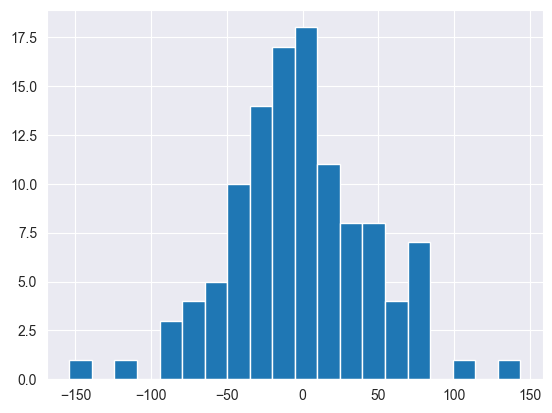

In [8]:
# Calculate summary of trades

n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Net Profit            : $%.2f" % df_trade.tail(1)['equity'])
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())
print("Profit Factor         : %.2f" % abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()))

df_trade['pnl'].hist(bins=20)

In [16]:
df_trade[df_trade['won'] == True]

,return,label,pred,won,pnl,equity
0,0.00028,1.0,1.0,True,2.799374,2.799374
4,0.00000,0.0,0.0,True,0.000000,-144.100608
6,0.00540,1.0,1.0,True,53.999358,-130.800440
9,0.00048,1.0,1.0,True,4.799887,-176.100883
13,-0.00224,0.0,0.0,True,22.399623,-274.602568
15,-0.00729,0.0,0.0,True,72.900196,-215.402324
16,-0.00180,0.0,0.0,True,18.000235,-197.402089
20,0.00144,1.0,1.0,True,14.401050,-278.901206
23,0.00720,1.0,1.0,True,72.000203,-257.000323
28,0.00310,1.0,1.0,True,31.000412,-301.001573


In [18]:
df_trade[df_trade['won'] == False]

,return,label,pred,won,pnl,equity
1,-0.00704,0.0,1.0,False,-70.399048,-67.599674
2,-0.00089,0.0,1.0,False,-8.900209,-76.499883
3,-0.00676,0.0,1.0,False,-67.600725,-144.100608
5,-0.00407,0.0,1.0,False,-40.699190,-184.799798
7,0.00135,1.0,0.0,False,-13.500306,-144.300746
...,...,...,...,...,...,...
105,0.00142,1.0,0.0,False,-14.199738,-334.996939
106,-0.00352,0.0,1.0,False,-35.200090,-370.197029
108,-0.00157,0.0,1.0,False,-15.700356,-377.597108
109,-0.00020,0.0,1.0,False,-1.999809,-379.596917
